In [2]:
import pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import h5py
import shutil
import pdb
import datetime
import os
from operator import truediv
import operator
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from scipy.optimize import leastsq

%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
corr_list = [4,11,17,22,27,28,29]
freq_phase = np.linspace(400,800,1024)
colors=['r','g','b','k','c','y','m']
legend_crosscorr = ["(0,4) A63","(1,4) A00","(2,4) A48","(3,4) A31","(5,4) B00","(6,4) B63","(7,4) B48"]

freq=462
num =14

In [5]:
def mag(tot_frames,corr_files):
        tot_magnitude = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        tot_magnitude_ref = np.zeros((tot_frames, 2, len(freq_phase[50:990])))
        x=0
        for corr_file in corr_files:
                for i in range(len(corr_list)):
                        frames =  corr_file['vis'][:].shape[0]
                        tot_magnitude[x:x+frames,i,:] = (np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2))
                tot_magnitude_ref[x:x+frames,0,:] = np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,27,50:990]['real'].astype(np.float)**2)
                tot_magnitude_ref[x:x+frames,1,:] = corr_file['vis'][:][:,27,50:990]
                x = x + frames

        return tot_magnitude,tot_magnitude_ref

In [39]:
unwrap_phase_required=[]
slope_required=[]
y_intercept_required=[]


def delay_unwrap(tot_frames,corr_files):
        delay = np.zeros((tot_frames,len(corr_list)))
        #phi = np.zeros((frames, len(corr_list), len(freq_phase[20:990])))# not taking some frequency bins
        kk=0
        delay_freq_bad_frame = np.zeros((len(corr_list),len(freq_phase[50:990])))
        kkk=0
        for corr_file in corr_files:
                vis = corr_file['vis'][:][:,corr_list,50:990]
                frames = corr_file['vis'][:].shape[0]
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                phi = np.arctan2((vis['imag']),(vis['real']))
                unwrap_phase_1 = np.unwrap(phi)
                unwrap_phase = unwrap_phase_1[:,::-1]/(2*np.pi)
                slope = [[0 for x in range(len(corr_list))] for y in range(frames)]
                for j in range(len(corr_list)):
                        slope_1 = []
                        for i in range(frames):
                                slope[i],b = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[i][j][:],1)
                                if i==1 and kk==0:
                                    unwrap_phase_required.append(unwrap_phase[i][j][:])
                                    slope_required.append(slope[i])
                                    y_intercept_required.append(b)
                                    
                                if slope[i]<0:
                                        slope[i] = slope[i]*(-1.0)
                                
                        delay[kk:kk+frames,j] = slope
                kk=kk+frames
                #pdb.set_trace()
        return np.array(delay),unwrap_phase, unwrap_phase_required, slope_required, y_intercept_required #

In [8]:
def data(chan):
        number_of_frame = corr_file['vis'][:].shape[0]
        print('Number of frames:' + str(number_of_frame))
        return number_of_frame

In [9]:
def get_timestamp(tot_frames,corr_files):
        cpu_cycle = np.zeros(tot_frames)
        x = 0
        for corr_file in corr_files:
                frame = corr_file['vis'][:].shape[0]
                timestamp = corr_file['timestamp']
                cpu_cycle[x:x+frame] = [time[1] for time in timestamp]
                x=x+frame
        return cpu_cycle


In [40]:
source_dir = ['C:/Users/sidhant/Desktop/data/20170407T194716Z_stone_corr/', 'C:/Users/sidhant/Desktop/data/20170410T180753Z_stone_corr/','C:/Users/sidhant/Desktop/data/20170414T020912Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170430T010748Z_stone_corr_one_file_deleted/', 'C:/Users/sidhant/Desktop/data/20170519T221539Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170525T174006Z_stone_corr_two_files_delated/'] #Apr 7-apr 10, #Apr 10-APR 13 #Apr 29 - May14
tot_frames = 0
corr_files=[]
for d in range(len(source_dir)):
    source_directory = source_dir[d]
    source_name = os.path.realpath(source_directory).split('/')[-1]
    active_dir = source_dir[d]
    all_file_names = os.listdir(active_dir)
    data_file_names = []
    for file_name in all_file_names:
        if ('.lock' not in file_name) and ('.h5' in file_name):
                data_file_names.append(file_name)
    data_file_names.sort()
    for file_name in data_file_names:
        corr_files.append(h5py.File(active_dir+file_name,'r'))

for corr_file in corr_files:
    frames = data(corr_list)
    tot_frames = tot_frames + frames
    

print(corr_files)

delay, unwrap_phase, phase_required, s, b = delay_unwrap(tot_frames,corr_files)

time_stamp = get_timestamp(tot_frames,corr_files)
#date_stamp = [datetime.datetime.fromtimestamp(time) + datetime.timedelta(hours = -7) for time in time_stamp]
date_stamp = [datetime.datetime.fromtimestamp(time)  for time in time_stamp]

Number of frames:360
Number of frames:61
Number of frames:360
Number of frames:119
Number of frames:360
Number of frames:360
Number of frames:360
Number of frames:264
Number of frames:360
Number of frames:360
Number of frames:54
Number of frames:360
[<HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216004_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00648000_0000.h5" (mode r)>, <HDF5 file "00863999_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00432001_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>]


In [53]:
print (freq_phase[50:990]*10**6)

[  4.19550342e+08   4.19941349e+08   4.20332356e+08   4.20723363e+08
   4.21114370e+08   4.21505376e+08   4.21896383e+08   4.22287390e+08
   4.22678397e+08   4.23069404e+08   4.23460411e+08   4.23851417e+08
   4.24242424e+08   4.24633431e+08   4.25024438e+08   4.25415445e+08
   4.25806452e+08   4.26197458e+08   4.26588465e+08   4.26979472e+08
   4.27370479e+08   4.27761486e+08   4.28152493e+08   4.28543500e+08
   4.28934506e+08   4.29325513e+08   4.29716520e+08   4.30107527e+08
   4.30498534e+08   4.30889541e+08   4.31280547e+08   4.31671554e+08
   4.32062561e+08   4.32453568e+08   4.32844575e+08   4.33235582e+08
   4.33626588e+08   4.34017595e+08   4.34408602e+08   4.34799609e+08
   4.35190616e+08   4.35581623e+08   4.35972630e+08   4.36363636e+08
   4.36754643e+08   4.37145650e+08   4.37536657e+08   4.37927664e+08
   4.38318671e+08   4.38709677e+08   4.39100684e+08   4.39491691e+08
   4.39882698e+08   4.40273705e+08   4.40664712e+08   4.41055718e+08
   4.41446725e+08   4.41837732e+08

In [87]:
print(unwrap_phase.shape)
print(unwrap_phase[1,1,1])
print (len(s))
print (len(b))
print(s[0])
print (type(phase_required))

(360, 7, 940)
-0.51257017786
7
7
-3.92044794171e-07
<class 'numpy.ndarray'>


rms linear residual 0.00439039747759
linear fit [ -3.92044794e-07   3.08056396e+02]
polynomial fit [ -3.91693890e-07  -1.71127106e-05   3.08263366e+02]
rms linear residual 0.00412747644134
rms linear residual 0.00374394209816
linear fit [ -3.91098687e-07   3.08039900e+02]
polynomial fit [ -3.90849999e-07  -1.21278834e-05   3.08186581e+02]
rms linear residual 0.00359057230407
73.6085571523
linear fit
73.6100710042
with sqrt
73.608892863
rms linear residual 0.00384686286163
linear fit [ -3.91774385e-07   3.08048744e+02]
polynomial fit [ -3.91411461e-07  -1.76988698e-05   3.08262804e+02]
rms linear residual 0.00352171222306
rms linear residual 0.00493246614516
linear fit [ -3.91692026e-07   3.08052786e+02]
polynomial fit [ -3.91343475e-07  -1.69979575e-05   3.08258369e+02]
rms linear residual 0.00470314735943


C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


rms linear residual 0.00411741405641
linear fit [ -3.91978160e-07   3.08049763e+02]
polynomial fit [ -3.91541511e-07  -2.12942456e-05   3.08307306e+02]
rms linear residual 0.00367223559675
rms linear residual 0.00359202821993
linear fit [ -3.88005077e-07   3.04991457e+02]
polynomial fit [ -3.87942465e-07  -3.05345907e-06   3.05028387e+02]
rms linear residual 0.0035821057841
rms linear residual 0.00331759888351
linear fit [ -3.92325694e-07   3.09104758e+02]
polynomial fit [ -3.91955371e-07  -1.80596931e-05   3.09323181e+02]
rms linear residual 0.00291755755298


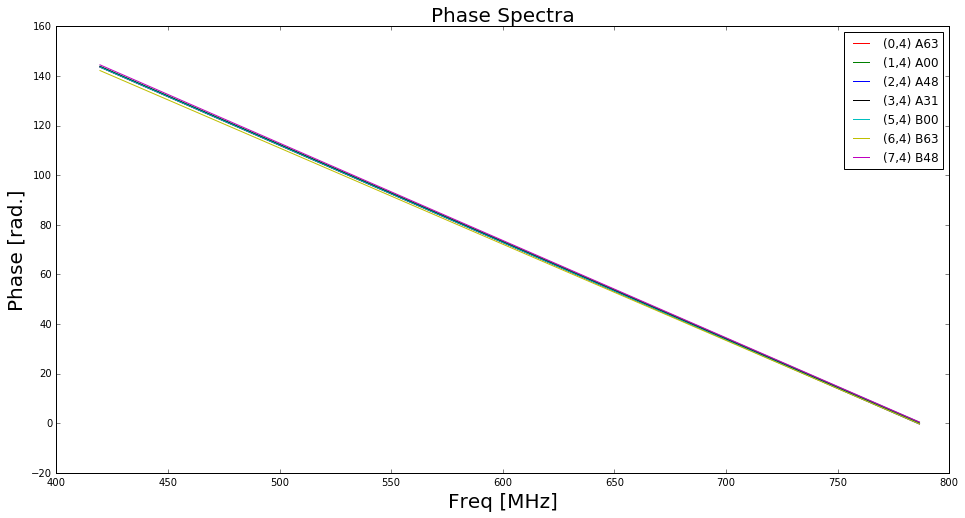

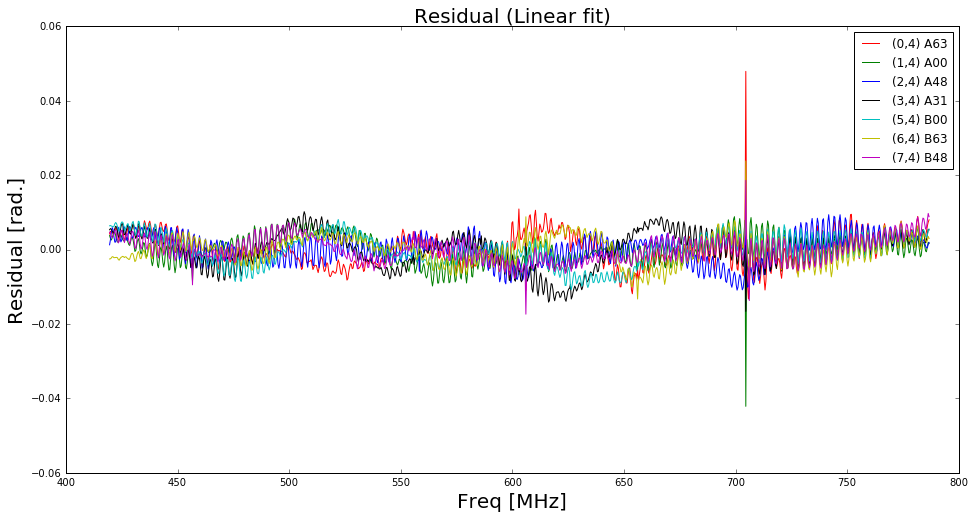

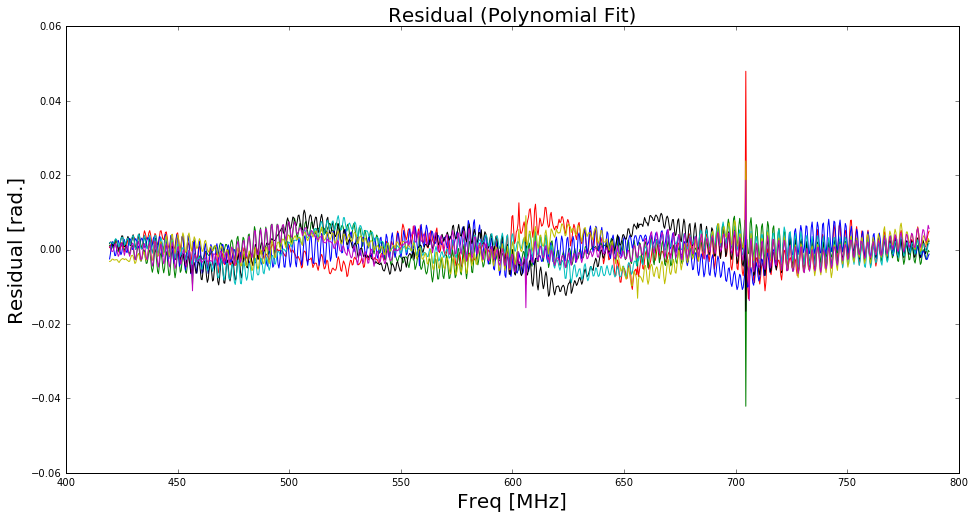

In [132]:
phase_required = np.array(phase_required)

linear_coeff=[]
polynomial_coeff=[]

for i in range(len(corr_list)):
    
    plt.figure(1)
    
    if s[i] < 0:
        phase_ref = -phase_required[i]
        plt.plot(freq_phase[50:990],(phase_ref[::-1]), color=colors[i],label=legend_crosscorr[i])
    else:
        phase_ref = phase_required[i]
        plt.plot(freq_phase[50:990],phase_ref[::-1], color=colors[i], label=legend_crosscorr[i])
        
    plt.legend()    
    p1 = np.polyfit(freq_phase[50:990]*10**6,phase_ref[::-1],1)
    plt.title('Phase Spectra', size=20)
    plt.ylabel('Phase [rad.]', size=20)
    plt.xlabel('Freq [MHz]', size=20)
    
    plt.figure(2)
    plt.plot(freq_phase[50:990], phase_ref[::-1] - (p1[0]*(freq_phase[50:990]*10**6)+p1[1]), color=colors[i], label=legend_crosscorr[i])
    #print(s[i])
    plt.title('Residual (Linear fit)', size=20)
    plt.xlabel('Freq [MHz]', size=20)
    plt.ylabel('Residual [rad.]', size=20)
    plt.legend()
    print('rms linear residual',np.std(phase_ref[::-1] - (p1[0]*(freq_phase[50:990]*10**6)+p1[1])))
    
    plt.figure(3)
    x0 = [1,1,1]
    p0, covar = curve_fit(fit_func, freq_phase[50:990]*10**6, phase_ref[::-1], p0 = x0)
    print('linear fit',p1)
    print ('polynomial fit',p0)
    plt.plot(freq_phase[50:990], phase_ref[::-1] - (p0[0]*(freq_phase[50:990]*10**6)+p0[1]*((freq_phase[50:990]*10**6)**0.5)+p0[2]),color=colors[i])
    plt.title('Residual (Polynomial Fit)', size=20)
    plt.xlabel('Freq [MHz]', size=20)
    plt.ylabel('Residual [rad.]', size=20)
    plt.legend()
    print('rms polynomial residual',np.std(phase_ref[::-1] - (p0[0]*(freq_phase[50:990]*10**6)+p0[1]*((freq_phase[50:990]*10**6)**0.5)+p0[2])))
    
    linear_coeff.append(p1)
    polynomial_coeff.append()
    if i==1:
        print((phase_ref[::-1])[460])
        print('linear fit'),
        print((p1[0]*(freq_phase[50:990]*10**6)+p1[1])[460])
        print('with sqrt'),
        print((p0[0]*(freq_phase[50:990]*10**6)+p0[1]*((freq_phase[50:990]*10**6)**0.5)+p0[2])[460])
    #print(p1)
    #print(p0)

In [115]:
freq_phase[50:990][460]

599.41348973607035

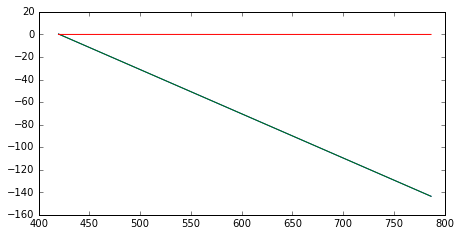

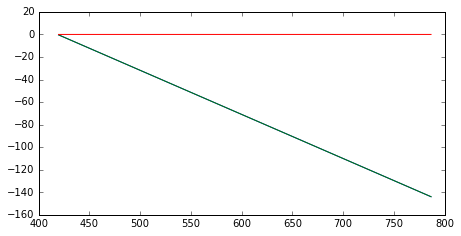

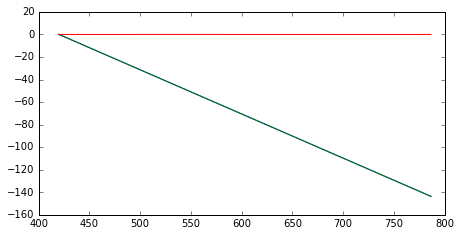

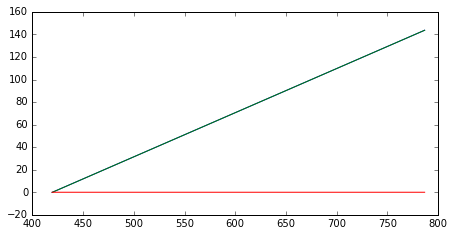

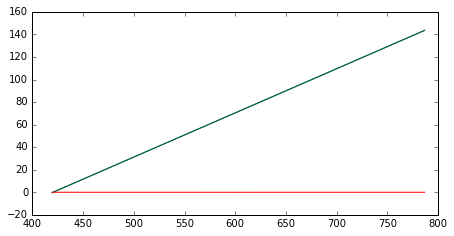

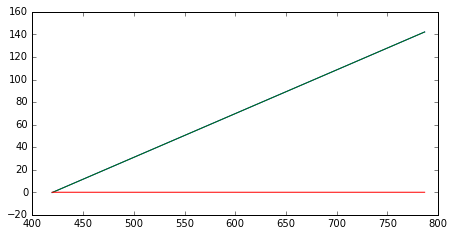

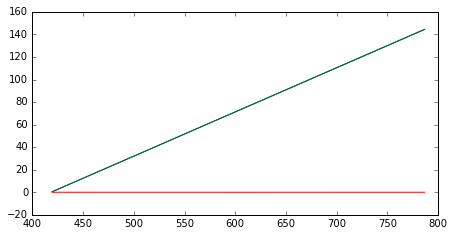

In [67]:
plt.figure(figsize(16,8))
for i in range(len(corr_list)):
    plt.figure(1)
    #plt.subplot(2,2,1)
    p1 = np.polyfit(freq_phase[50:990]*10**6,phase_required[i],1)
    plt.plot(freq_phase[50:990], phase_required[i] )
    
    #plt.subplot(2,2,2)
    plt.plot(freq_phase[50:990],  p1[0]*(freq_phase[50:990]*10**6)+p1[1])
    
    plt.subplot(2,2,1)
    plt.plot(freq_phase[50:990], phase_required[i] - (p1[0]*(freq_phase[50:990]*10**6)+p1[1]))

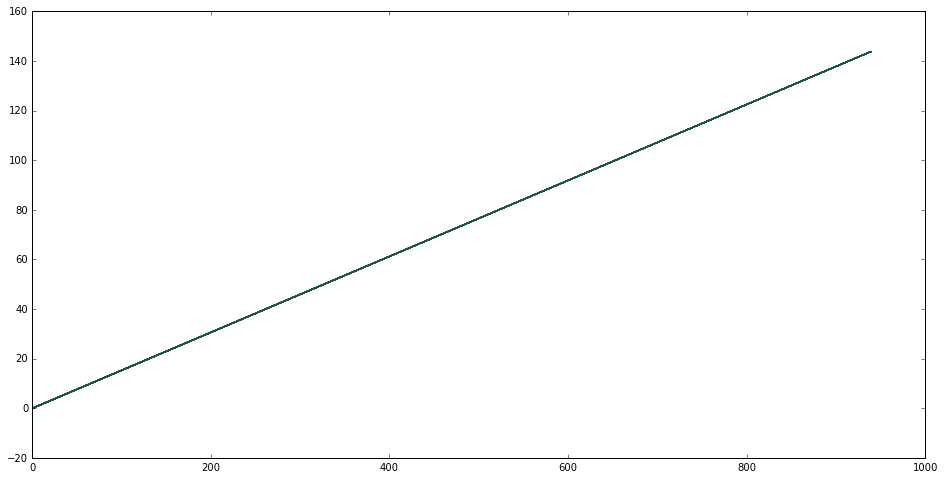

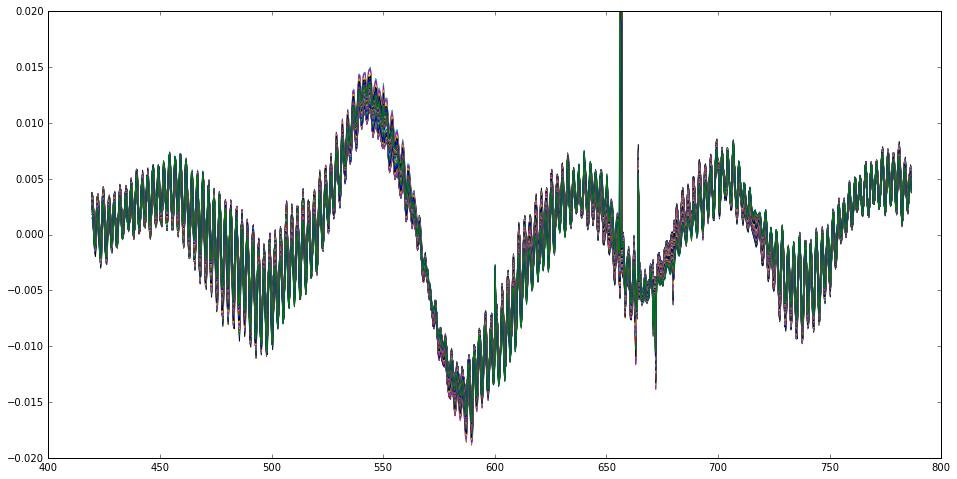

In [73]:
for i in range(100):
    plt.figure(1)
    plt.plot(unwrap_phase[i,3,:])
    plt.figure(2)
    p1 = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[i,3,:],1)
    plt.plot(freq_phase[50:990], unwrap_phase[i,3,:] - (p1[0]*(freq_phase[50:990]*10**6)+p1[1]))
    plt.ylim(-0.02,0.02)

In [130]:
def fit_func(freq,a,b,c):
    return a*freq + b*np.sqrt(freq) + c

[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]
[  3.92671993e-07  -1.71386495e-05  -1.63926819e+02]


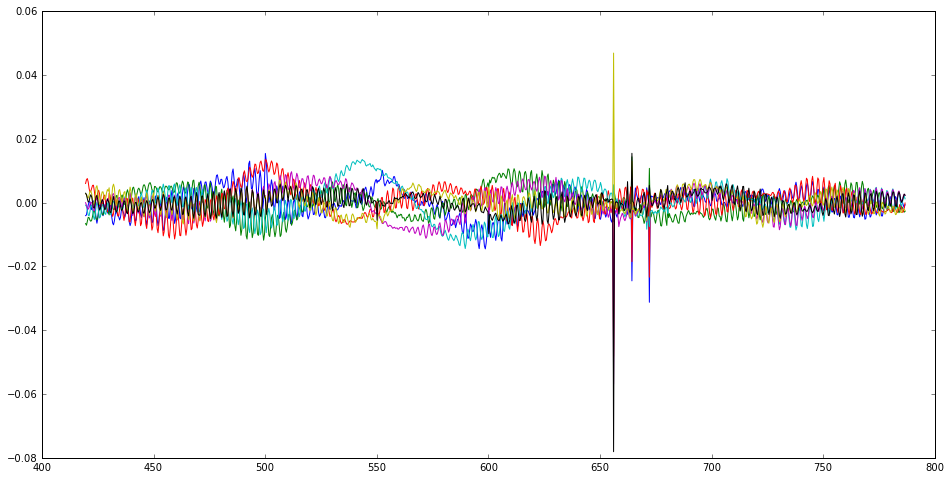

In [103]:
for i in range(len(corr_list)):

    plt.figure(1)
    x0 = [1,1,1]
    p1, covar = curve_fit(fit_func, freq_phase[50:990]*10**6, unwrap_phase[0,i,:], p0 = x0)
    p1 = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[0,1,:],1)
    plt.plot(freq_phase[50:990], unwrap_phase[0,i,:] - (p1[0]*(freq_phase[50:990]*10**6)+p1[1]*((freq_phase[50:990]*10**6)**0.5)+p1[2]))
    #plt.ylim(-0.02,0.02)
    print (best_vals)
    plt.figure(2)
    